In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats


In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
print(tf.__version__)

2.6.0


In [3]:
df=pd.read_excel('appdata.xlsx')

In [55]:
# df=pd.read_csv('test_appdata.csv')

In [4]:
df.head()

,timeElapsed,x,y,z,label
0,0,9.38,-1.48,2.62,Sitting
1,1,9.37,-1.47,2.64,Sitting
2,2,9.39,-1.49,2.64,Sitting
3,3,9.37,-1.49,2.62,Sitting
4,4,9.38,-1.50,2.62,Sitting


In [57]:
df['label'].value_counts()

Walking       100033
Sitting        91000
Upstairs       66095
Downstairs     42443
Standing       42353
Name: label, dtype: int64

In [58]:
from sklearn.preprocessing import LabelEncoder

In [5]:
label = LabelEncoder()
df['ActivityLabel'] = label.fit_transform(df['label'])
df.tail()

,timeElapsed,x,y,z,label,ActivityLabel
817802,817802,3.15,-9.50,0.23,Standing,2
817803,817803,3.42,-9.57,0.24,Standing,2
817804,817804,3.64,-9.22,0.23,Standing,2
817805,817805,3.39,-9.01,0.23,Standing,2
817806,817806,3.45,-9.09,0.21,Standing,2


In [6]:
label.classes_



array(['Downstairs', 'Sitting', 'Standing', 'Upstairs', 'Walking'],
      dtype=object)

### Standardized data 

In [7]:
X = df[['x', 'y', 'z']]
y = df['ActivityLabel']

In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['ActivityLabel'] = y.values

scaled_X

,x,y,z,ActivityLabel
0,1.482169,0.381171,0.462761,1
1,1.479849,0.382733,0.466161,1
2,1.484489,0.379608,0.466161,1
3,1.479849,0.379608,0.462761,1
4,1.482169,0.378045,0.462761,1
...,...,...,...,...
817802,0.036749,-0.872110,0.056478,2
817803,0.099392,-0.883049,0.058178,2
817804,0.150434,-0.828355,0.056478,2
817805,0.092431,-0.795538,0.056478,2


### Frame Preparation 

In [9]:
Fs = 50
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

In [10]:
def get_frames(df, frame_size, hop_size):
    N_FEATURES = 3
    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
        # Retrieve the most often used label in this segment
        label = stats.mode(df['ActivityLabel'][i: i + frame_size])[0][0]

        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [11]:
X, y = get_frames(scaled_X, frame_size, hop_size)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

In [13]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 3, 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 3, 1)

In [14]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))


In [15]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [16]:
history = model.fit(X_train, y_train, epochs = 40, validation_data= (X_test, y_test), verbose=1)

Epoch 1/40
179/179 [==============================] - 5s 17ms/step - loss: 0.7974 - accuracy: 0.6914 - val_loss: 0.5618 - val_accuracy: 0.7812
Epoch 2/40
179/179 [==============================] - 3s 16ms/step - loss: 0.6019 - accuracy: 0.7748 - val_loss: 0.5240 - val_accuracy: 0.7922
Epoch 3/40
179/179 [==============================] - 3s 16ms/step - loss: 0.5451 - accuracy: 0.7863 - val_loss: 0.4831 - val_accuracy: 0.8150
Epoch 4/40
179/179 [==============================] - 3s 16ms/step - loss: 0.5179 - accuracy: 0.8019 - val_loss: 0.4813 - val_accuracy: 0.8150
Epoch 5/40
179/179 [==============================] - 3s 16ms/step - loss: 0.4801 - accuracy: 0.8113 - val_loss: 0.4648 - val_accuracy: 0.8215
Epoch 6/40
179/179 [==============================] - 3s 16ms/step - loss: 0.4501 - accuracy: 0.8212 - val_loss: 0.4541 - val_accuracy: 0.8227
Epoch 7/40
179/179 [==============================] - 3s 18ms/step - loss: 0.4390 - accuracy: 0.8230 - val_loss: 0.4436 - val_accuracy: 0.8268

In [17]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [18]:
pred = model.predict(X_test, batch_size = 32)
pred = np.argmax(pred, axis=1)

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x120be265608>)

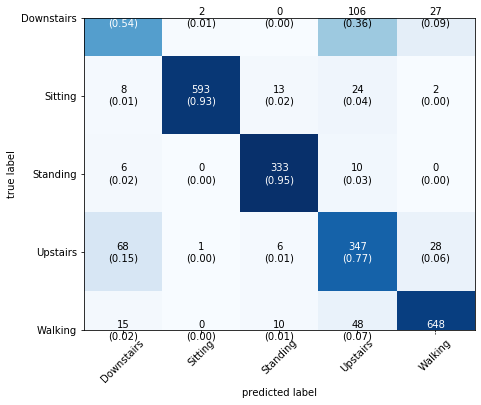

In [19]:
import seaborn as sns
mat = confusion_matrix(y_test, pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

Confusion matrix is :
  [[159   2   0 106  27]
 [  8 593  13  24   2]
 [  6   0 333  10   0]
 [ 68   1   6 347  28]
 [ 15   0  10  48 648]]


NameError: name 'z' is not defined

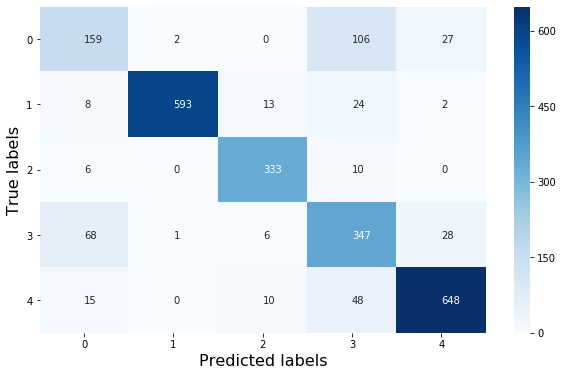

In [21]:
import matplotlib.pyplot as plt
z=label.inverse_transform(np.unique(y_labeled))

cm = confusion_matrix(y_test, pred)
print("Confusion matrix is :\n ", cm)
annot_kws = {"ha": 'left',"va": 'center','size': 10}
plt.figure(figsize=(10,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', cmap = 'Blues',annot_kws=annot_kws, ax=ax); 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
# labels, title and ticks
ax.set_xlabel('Predicted labels',fontsize=16)
ax.set_ylabel('True labels',fontsize=16); 
#ax.set_title('DecisionTree Confusion Matrix',fontsize=16); 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10,rotation=0)
ax.xaxis.set_ticklabels(z);
ax.yaxis.set_ticklabels(z);
plt.savefig('DT.png')

In [53]:
score = model.evaluate(X_test, pred, verbose=0)
print("test loss, test acc:", score)

test loss, test acc: [0.1390361338853836, 1.0]


In [54]:
from sklearn.metrics import  accuracy_score

print('Accuracy --------->',round(accuracy_score(y_test, pred),2))

Accuracy ---------> 0.84


### Accuracy of independet data


In [66]:
X = X.reshape(X.shape[0], X.shape[1], 3, 1)

In [67]:
pred = model.predict(X, batch_size = 32)
pred = np.argmax(pred, axis=1)

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1850f765848>)

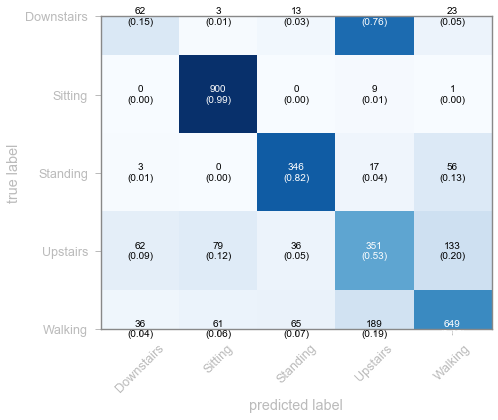

In [68]:
mat = confusion_matrix(y, pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

In [70]:
from sklearn.metrics import  accuracy_score

print('Accuracy dependent --------->',round(accuracy_score(y, pred),2))

Accuracy dependent ---------> 0.68
